In [1]:
import numpy as np 
import os
import copy
from math import *
import matplotlib.pyplot as plt
from functools import reduce

import pydicom

import glob
import pylab, pandas as pd
from collections import defaultdict
import pickle
import matplotlib.pyplot as plt
import matplotlib.patches
from PIL import Image

С помощью следующих функций свизуализируем данные изображения.

In [2]:
def load_scan(path):
    slices = [pydicom.dcmread(path + "/" + s) for s in               
              os.listdir(path)]
    slices = [s for s in slices if "SliceLocation" in s]
    slices.sort(key = lambda x: int(x.InstanceNumber))
    try:
        slice_thickness = np.abs(slices[0].ImagePositionPatient[2] - slices[1].ImagePositionPatient[2])
    except:
        slice_thickness = np.abs(slices[0].SliceLocation - slices[1].SliceLocation)
    for s in slices:
        s.SliceThickness = slice_thickness
    return slices
def get_pixels_hu(scans):
    image = np.stack([s.pixel_array for s in scans])
    image = image.astype(np.int16)
    image[image == -2000] = 0
    
    intercept = scans[0].RescaleIntercept
    slope = scans[0].RescaleSlope
    
    if slope != 1:
        image = slope * image.astype(np.float64)
        image = image.astype(np.int16)
        
    image += np.int16(intercept)
    
    return np.array(image, dtype=np.int16)

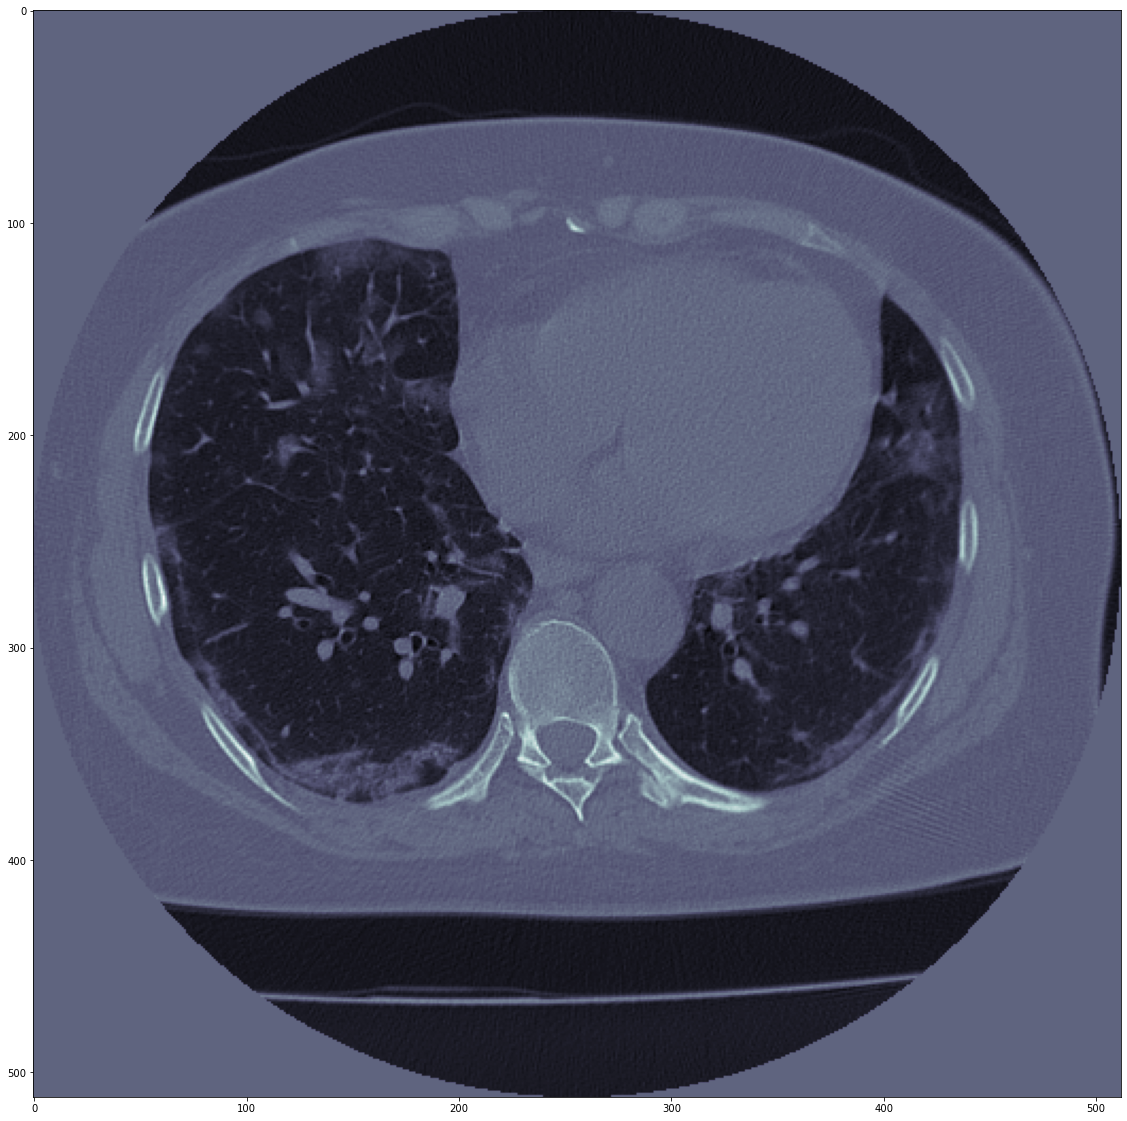

In [3]:
path = "../input/dcm-dir"
patient_dicom = load_scan(path)
patient_pixels = get_pixels_hu(patient_dicom)
plt.figure(figsize = (50,20))
plt.imshow(patient_pixels[0], cmap=plt.cm.bone)


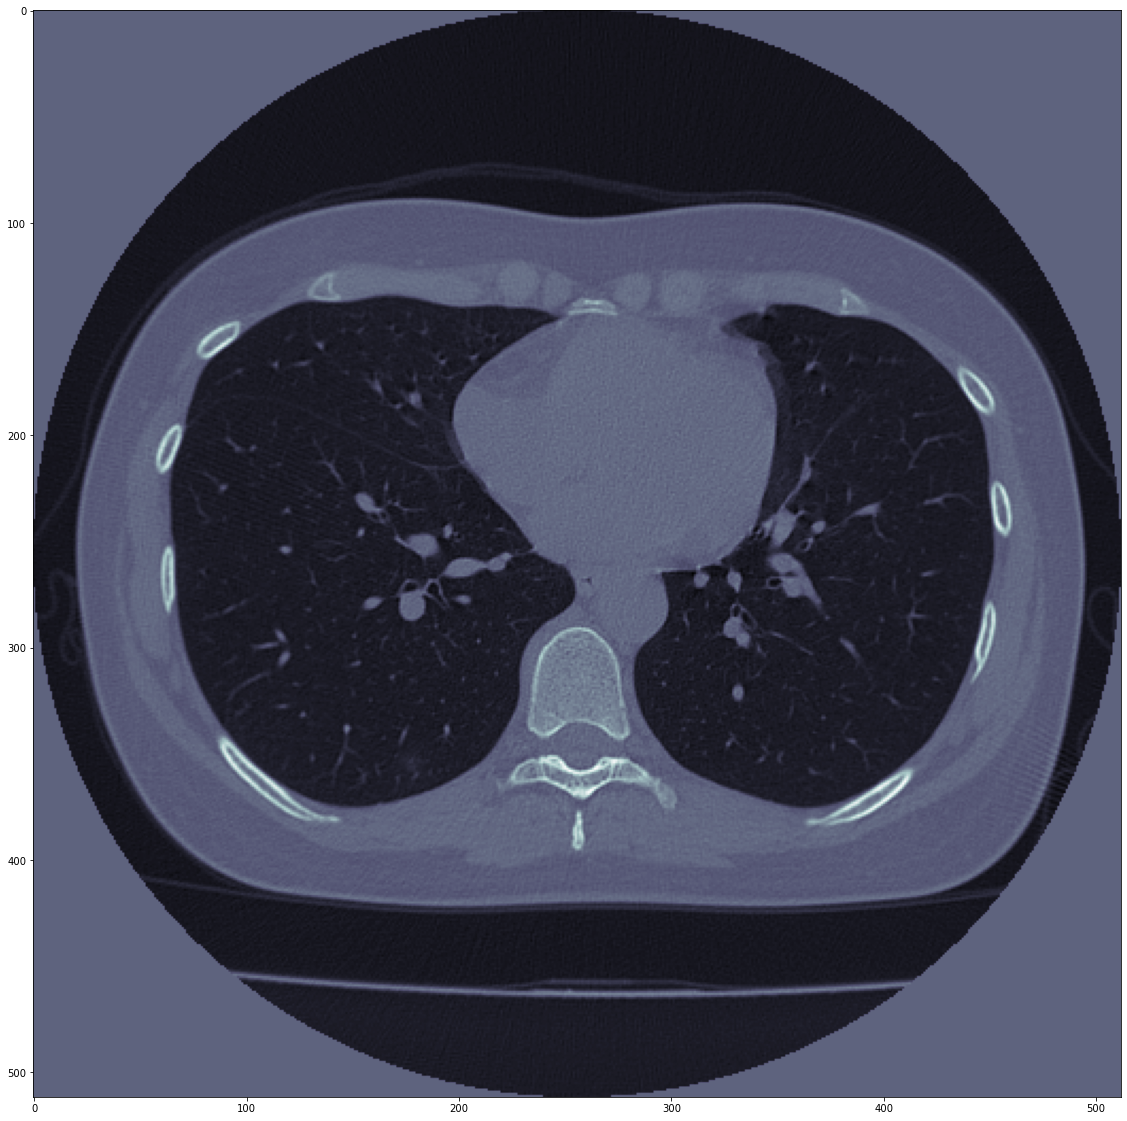

In [4]:
plt.figure(figsize = (50,20))
plt.imshow(patient_pixels[1], cmap=plt.cm.bone)


Похоже на КТ легких. Далее просмотрим файл с описанием test.csv

In [5]:
df = pd.read_csv('../input/testtest/test.csv')
df

doc_name                                        ohif_markup  \
0         0  {"ohifMarks":[{"visible":true,"active":false,"...   
1         1  {"ohifMarks":[{"visible":true,"active":false,"...   
2         2  {"ohifMarks":[{"visible":true,"active":false,"...   
3         3  {"ohifMarks":[{"visible":true,"active":false,"...   
4         0  {"ohifMarks":[{"visible":true,"active":false,"...   
5         1  {"ohifMarks":[{"visible":true,"active":true,"i...   
6         2  {"ohifMarks":[{"visible":true,"active":false,"...   
7         3  {"ohifMarks":[{"visible":true,"active":false,"...   

                                       path  
0  0b791bcb-a3f6-11ea-8690-d5dc0d8782d9.dcm  
1  0b791bcb-a3f6-11ea-8690-d5dc0d8782d9.dcm  
2  0b791bcb-a3f6-11ea-8690-d5dc0d8782d9.dcm  
3  0b791bcb-a3f6-11ea-8690-d5dc0d8782d9.dcm  
4  29a7b38f-a3f6-11ea-8690-0ff0934ed20e.dcm  
5  29a7b38f-a3f6-11ea-8690-0ff0934ed20e.dcm  
6  29a7b38f-a3f6-11ea-8690-0ff0934ed20e.dcm  
7  29a7b38f-a3f6-11ea-8690-0ff0934ed20e.dcm

Далее при помощи библиотеки парсим строку в формате json и данные записываем в новую структуру.

In [7]:
import json


res_list = []
parsed = {}
for n, row in df.iterrows():
    pid = row['path']
    doc_pid = row['doc_name']
    common_pid = str(doc_pid) + "___" + pid
    json_data = json.loads(df['ohif_markup'][n])
    a = json_data["ohifMarks"]
    b = a[0]['handles']['points']
    
    try: 
        target = a[0]['location']
    except KeyError:
        target = "unknown"
    else:
        "nothing"
    #print(target)    
    res_list = []
    for i in range(len(b)):
        tmp_list = []
        x1 = b[i]['x']
        y1 = b[i]['y']
        tmp_list.append(x1)
        tmp_list.append(y1)
        res_list.append(tmp_list)    
    
    parsed[common_pid] = {
                'doc_name': doc_pid,
                'dicom': '../input/dcm-dir/%s' % pid,
                'label': target,
                'boxes': res_list}

    
    #print(n)
    #print(pid +  "  " + str(doc_pid))
    #print(res_list)
    

 Далее из записанной структуры достаем нужны данные, а именно точки, записанные в 'boxes'. И прорисовываем поточечно нужную площадь с помощью следующих функций.

In [8]:
def draw(data):
    d = pydicom.read_file(data['dicom'])
    im = d.pixel_array
    im = np.stack([im] * 3, axis=2)

    for box in data['boxes']:
        rgb = (255,0,0)
        im = overlay_box(im=im, box=box, rgb=rgb, stroke=6)
   
    pylab.figure(figsize = (400,50))
    pylab.imshow(im, cmap=pylab.cm.bone)
    pylab.axis('off')

def overlay_box(im, box, rgb, stroke=1):
    box = [int(b) for b in box]
    x1, y1 = box
    im[y1, x1] = rgb

    return im

Ниже при помощи предыдущей функции мы на изображениях выделим разметку от соответствующего врача. 

unknown
mass
ground_glass
ground_glass
pneumonia
ground_glass
consolidation
ground_glass


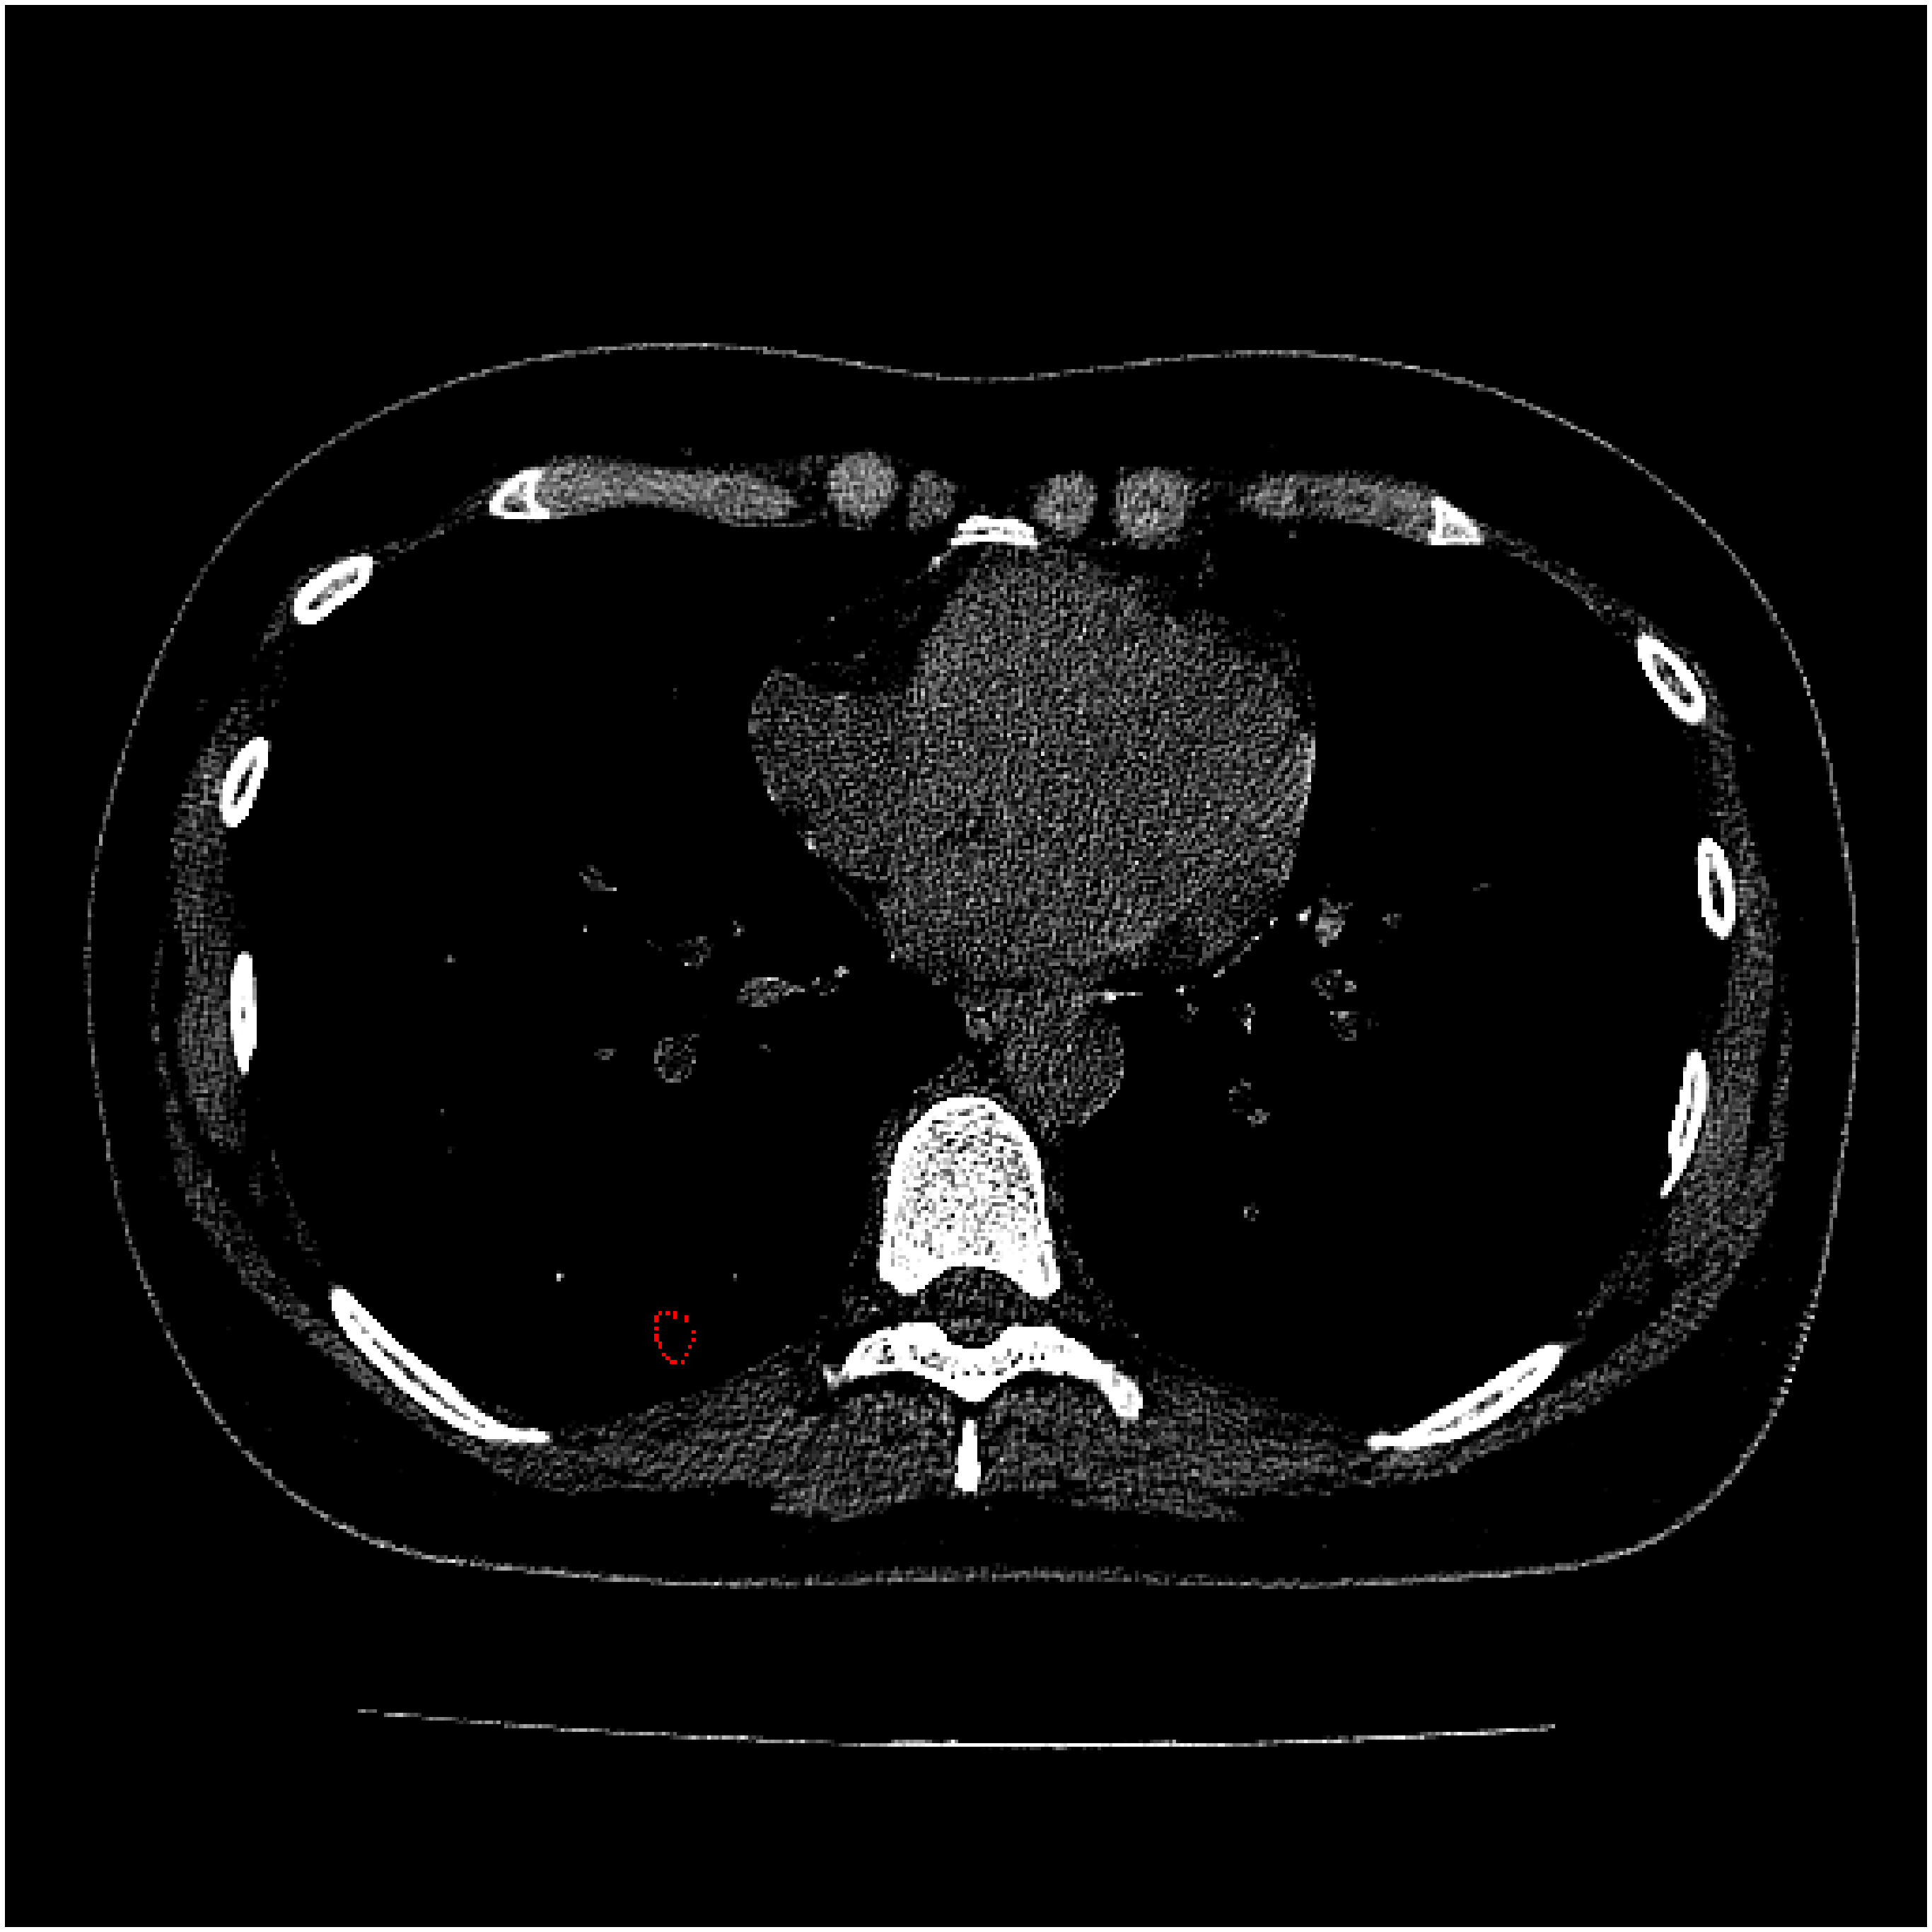

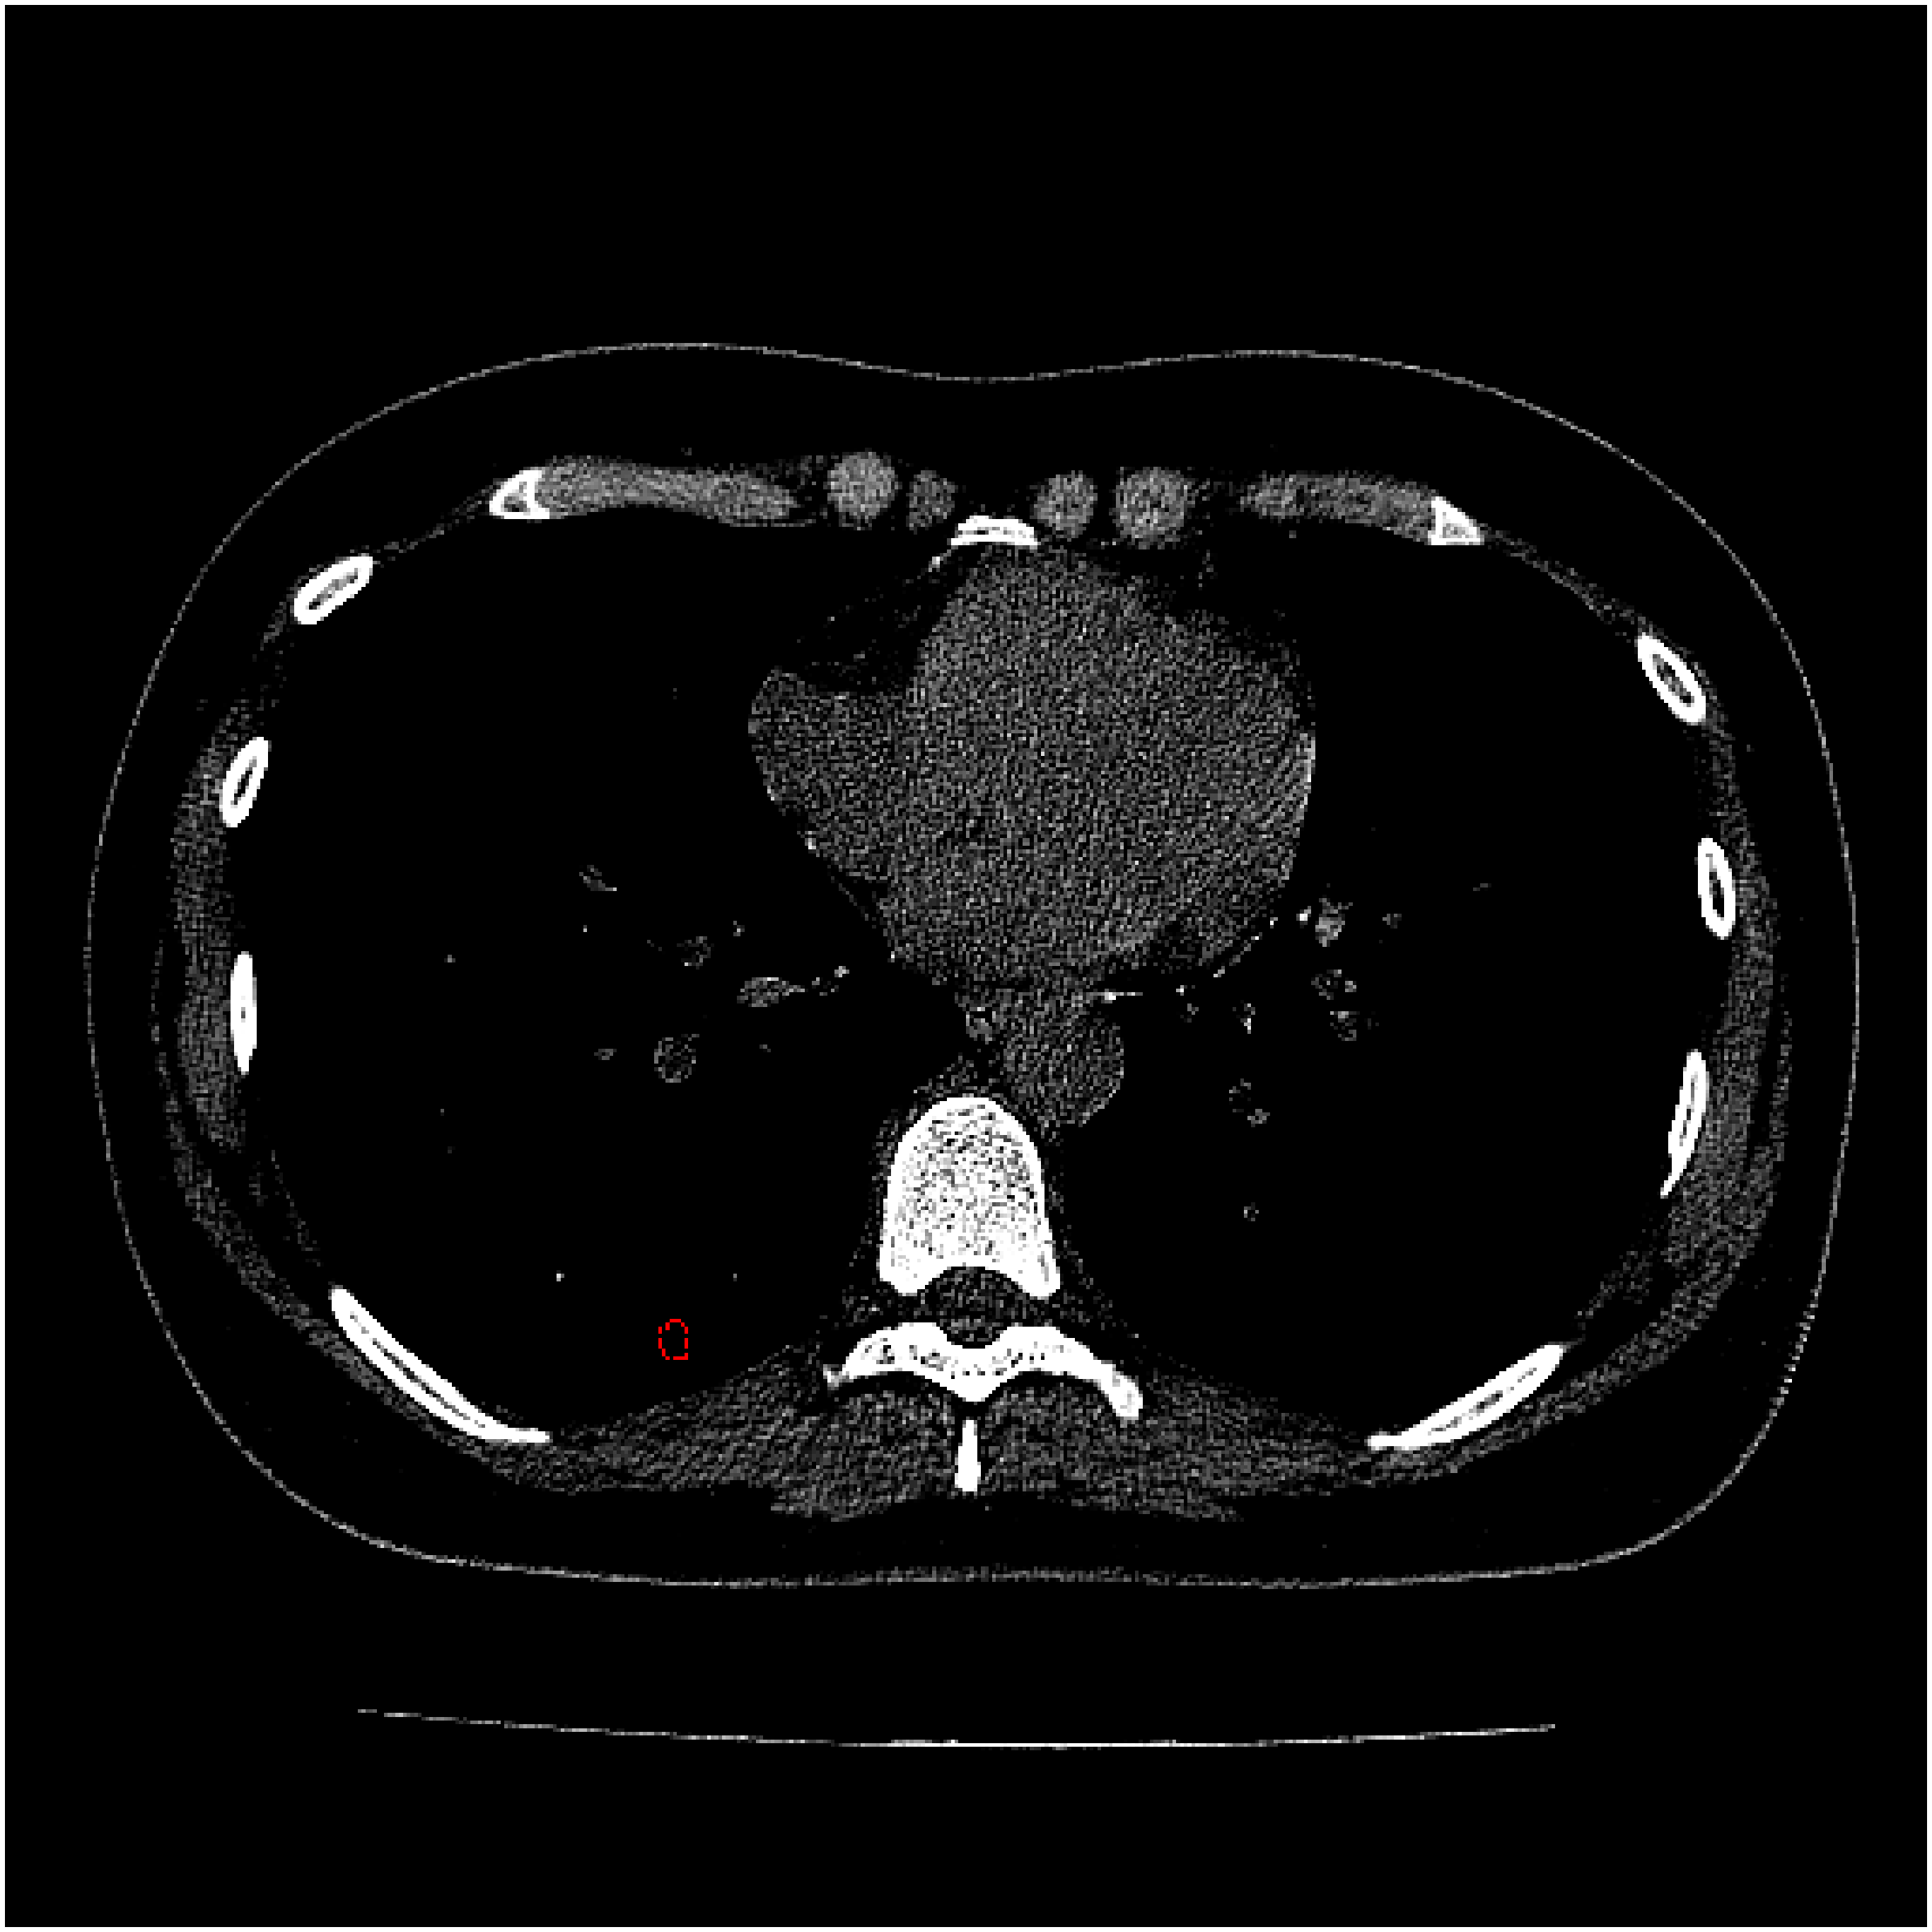

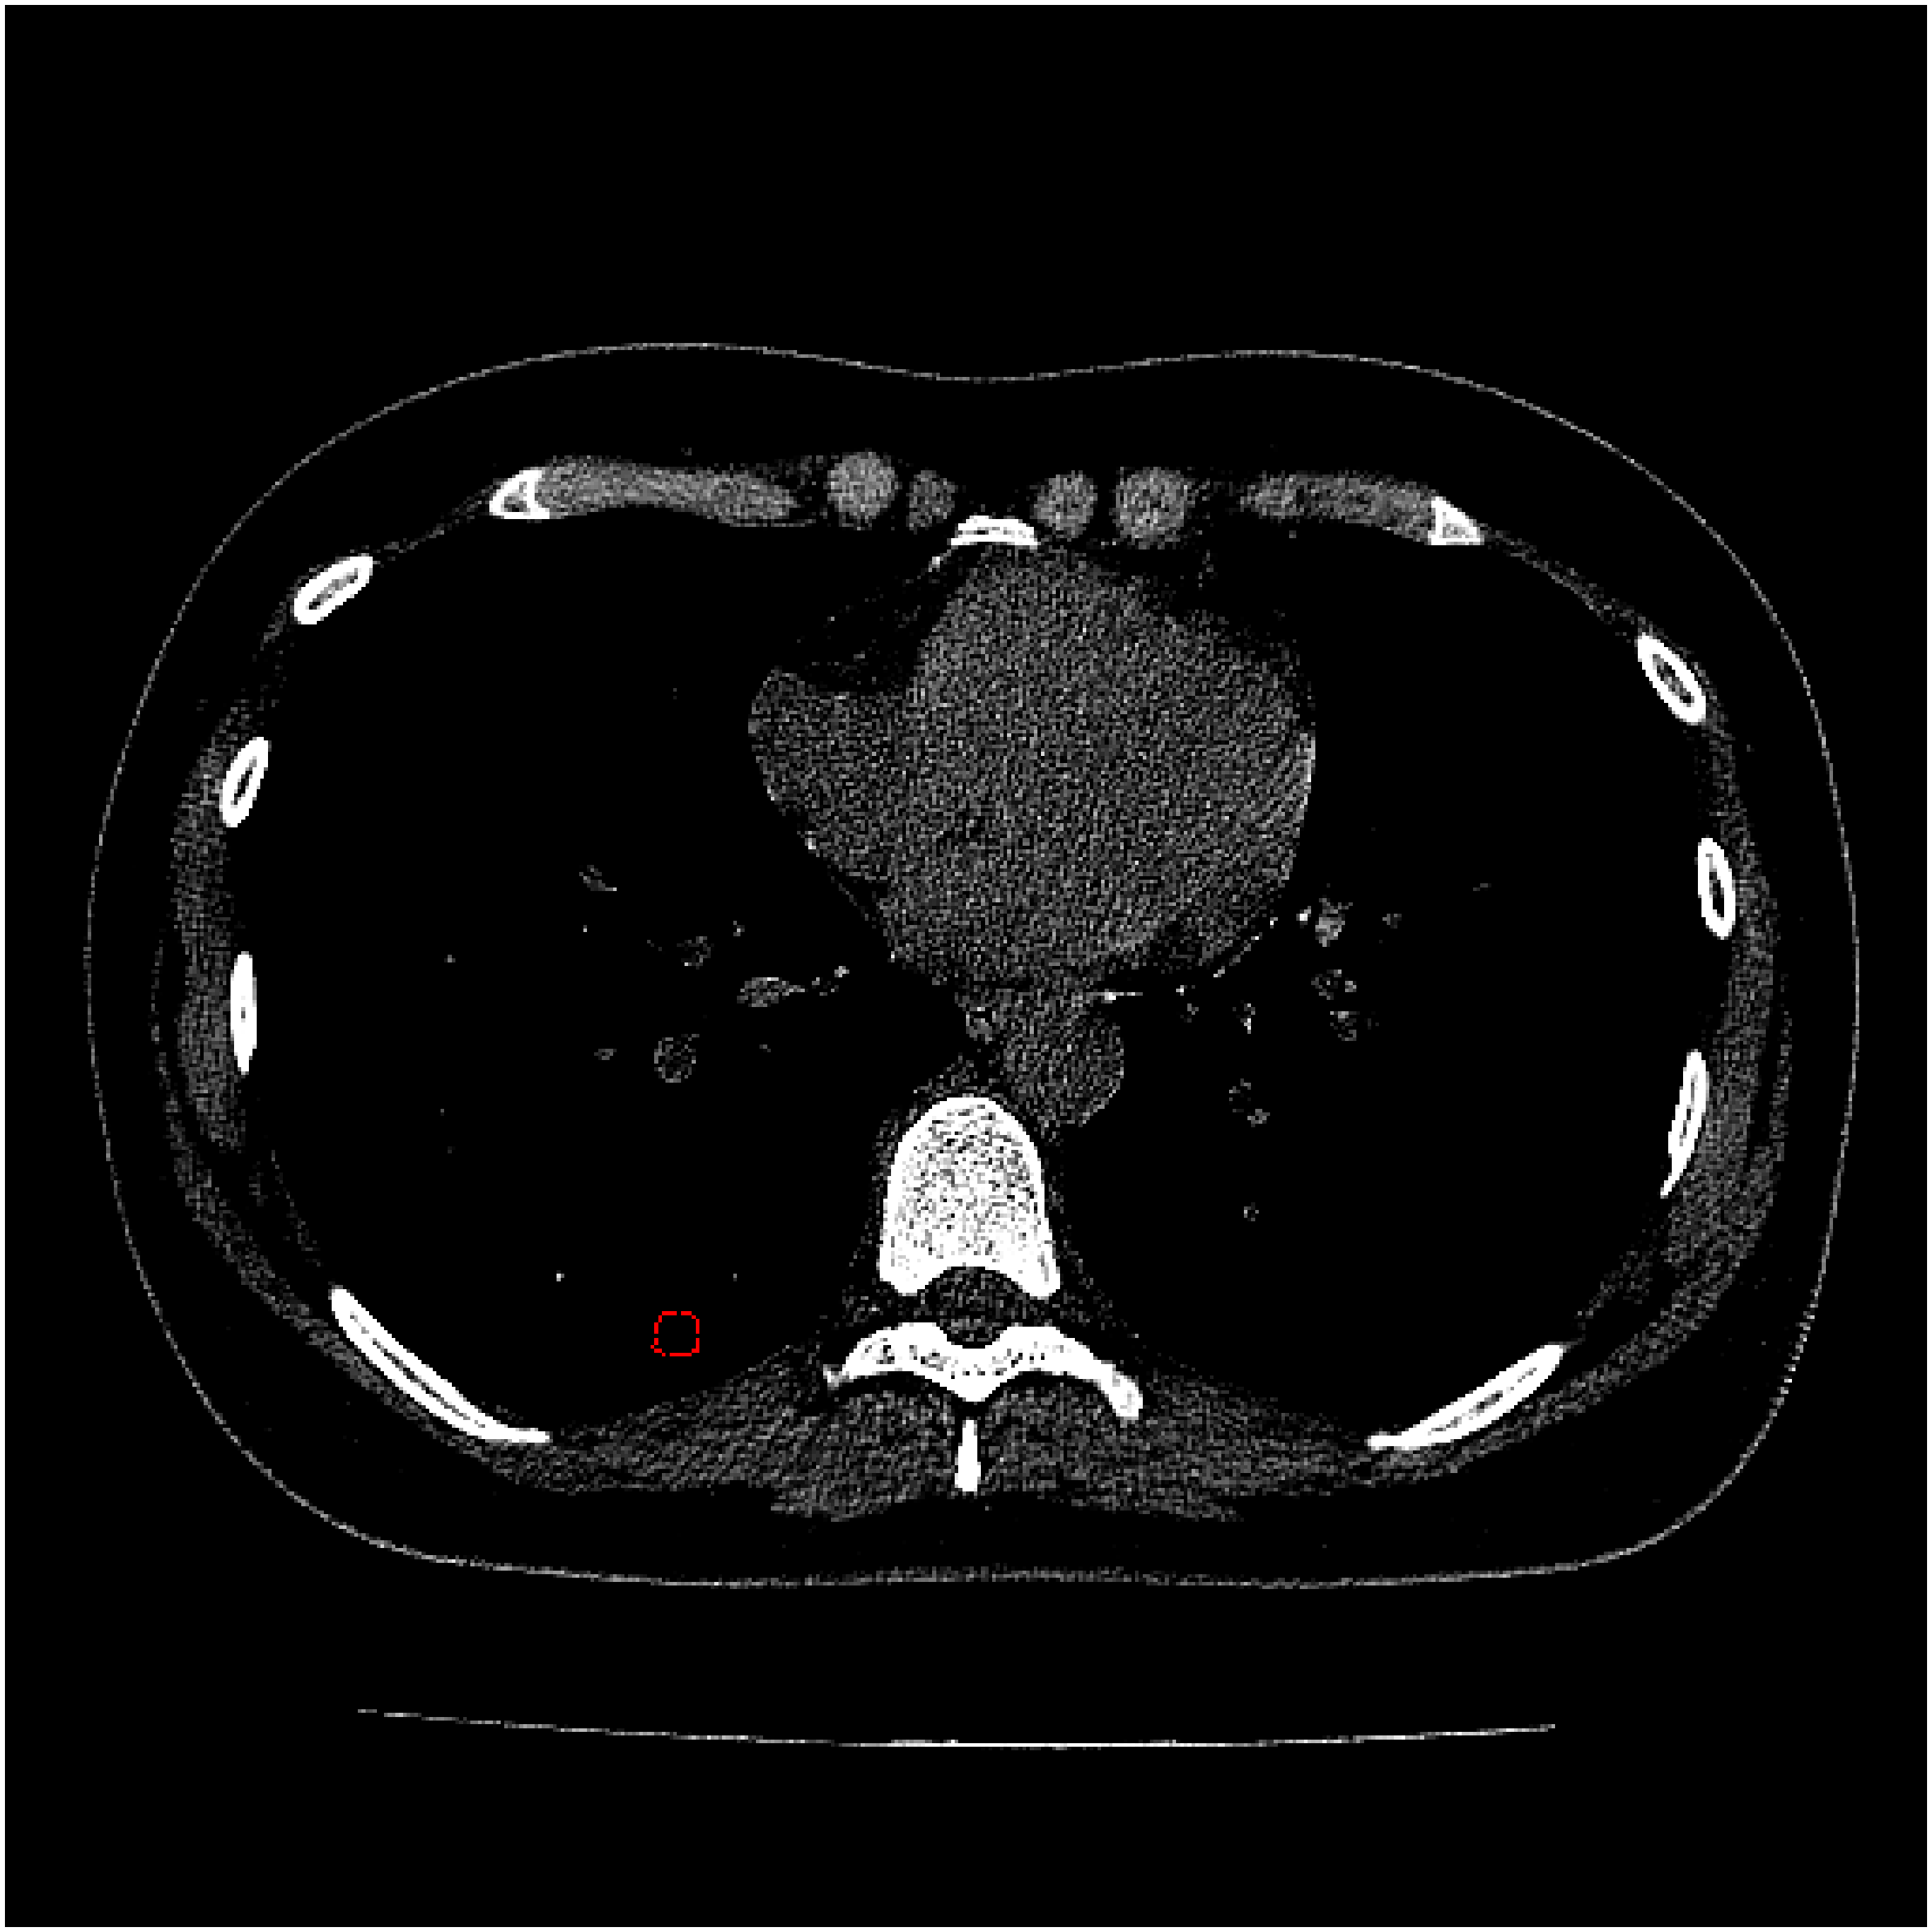

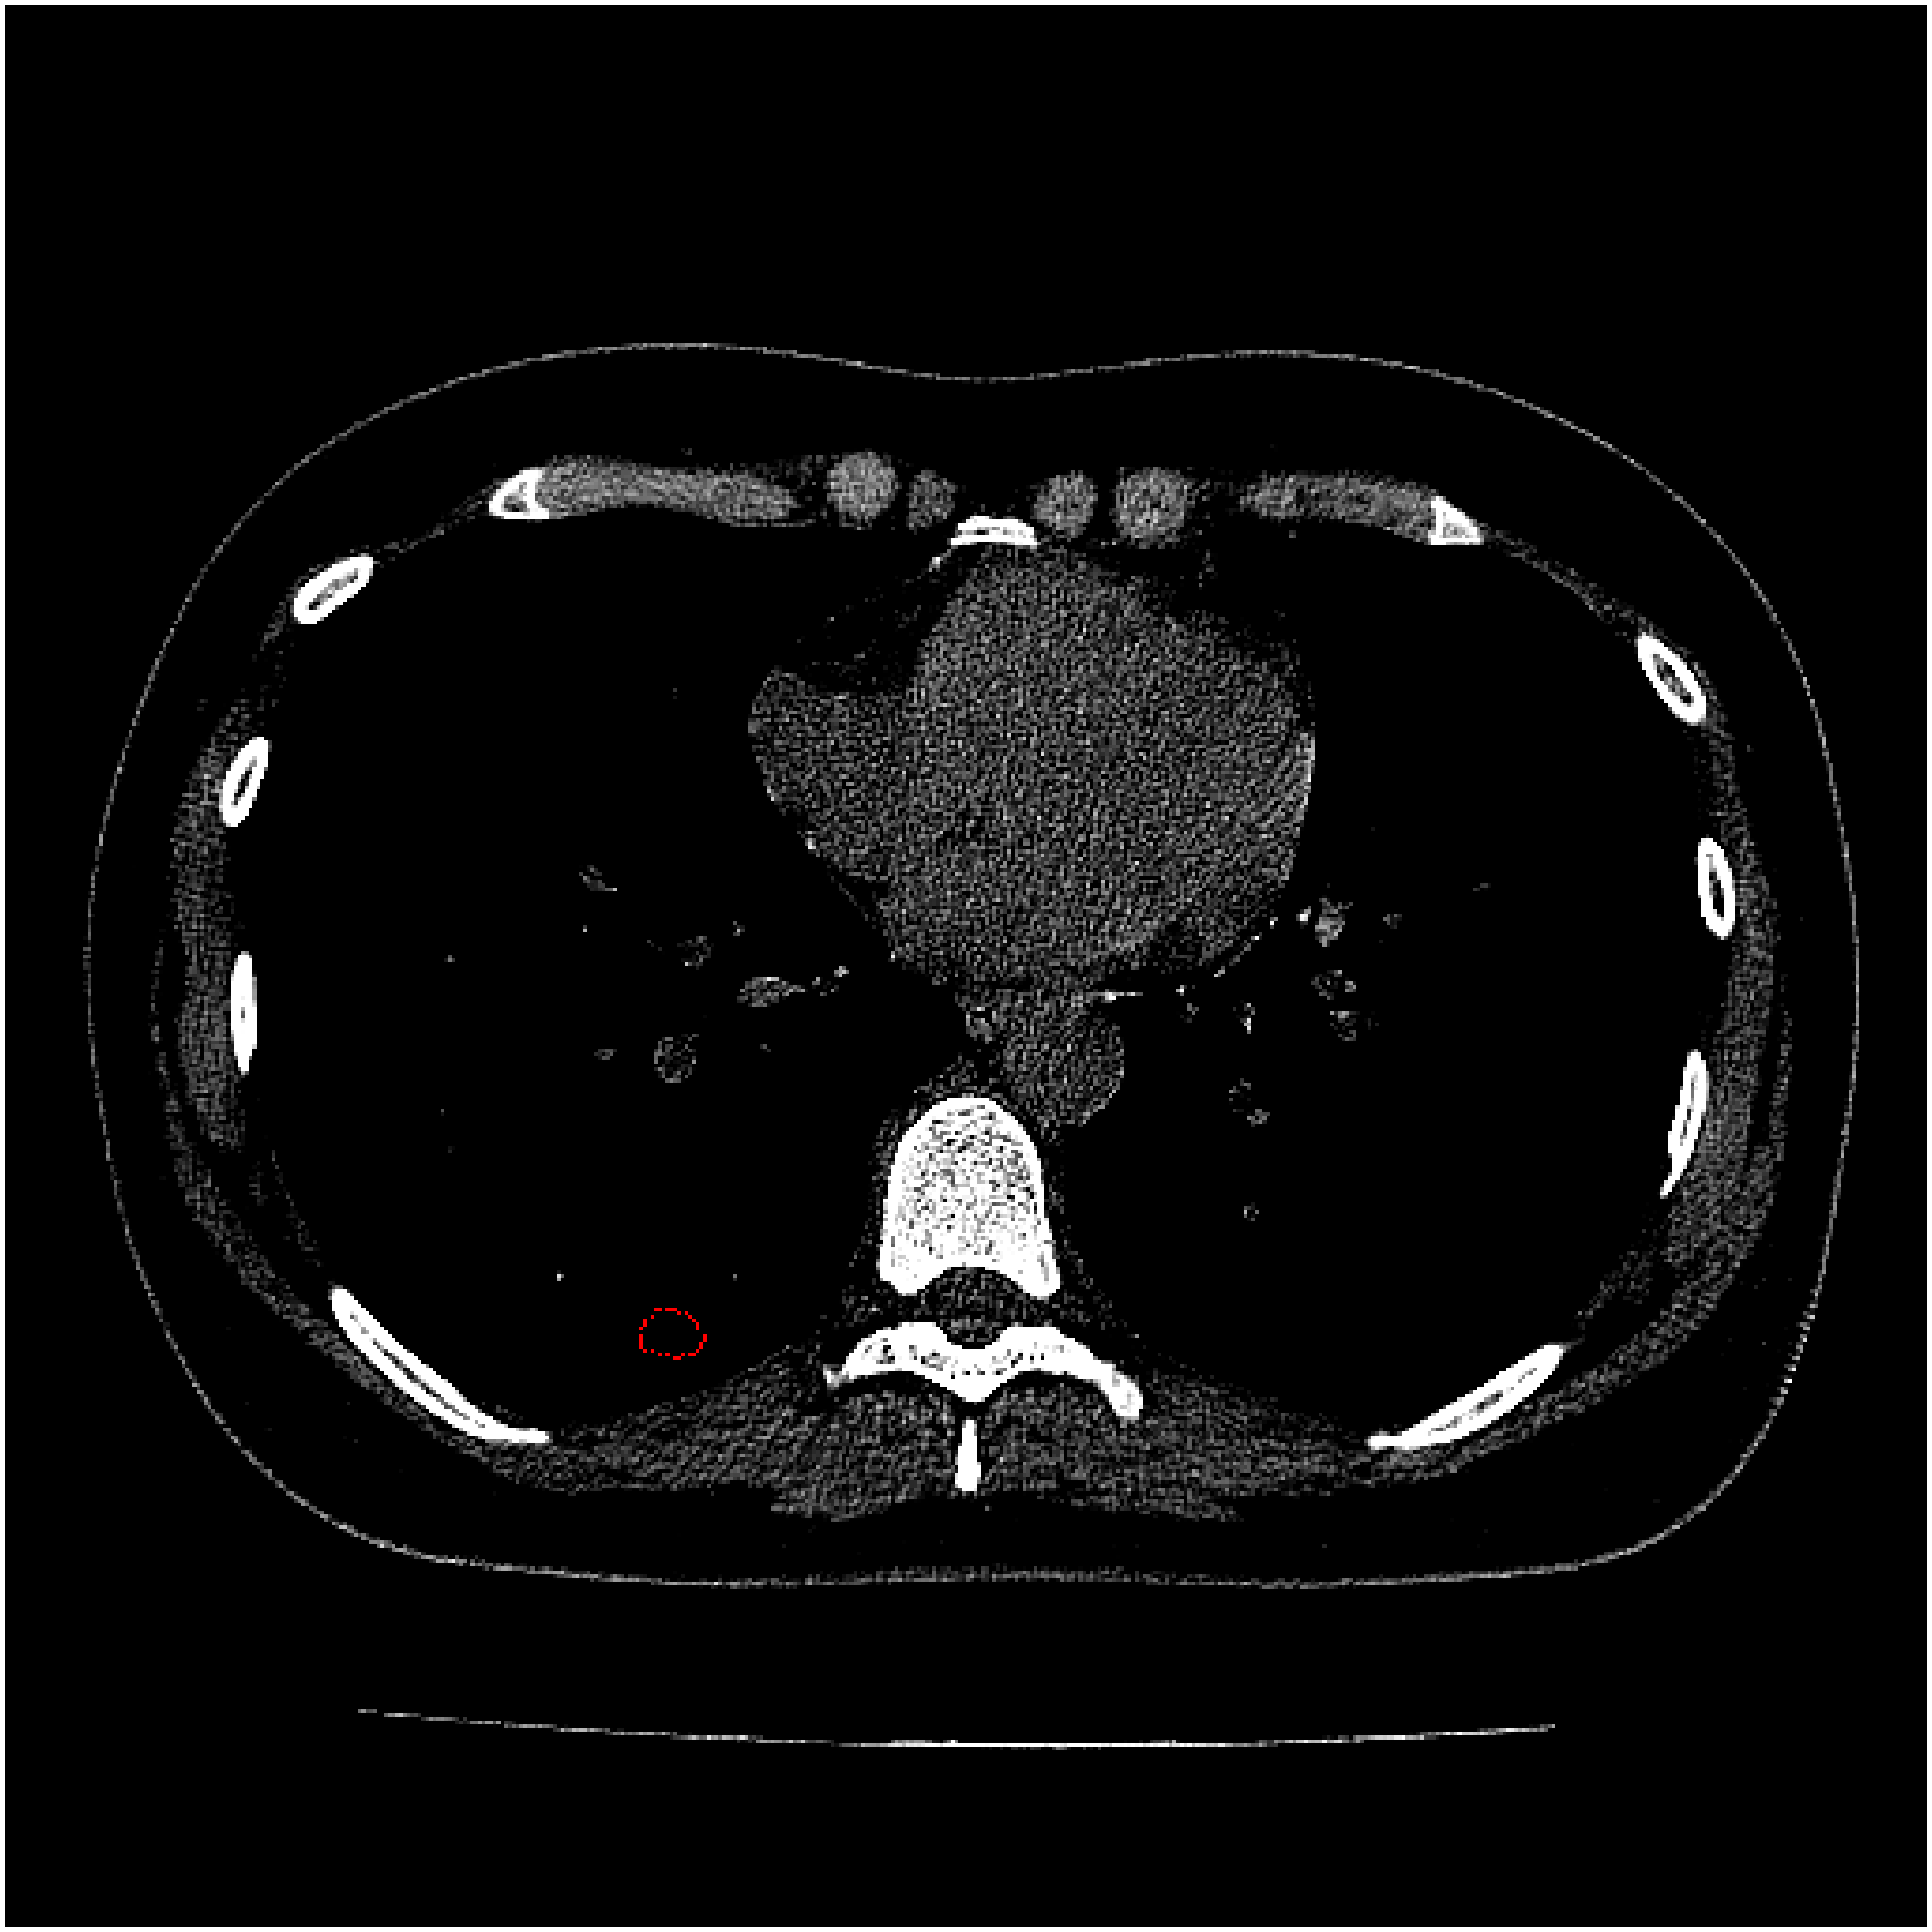

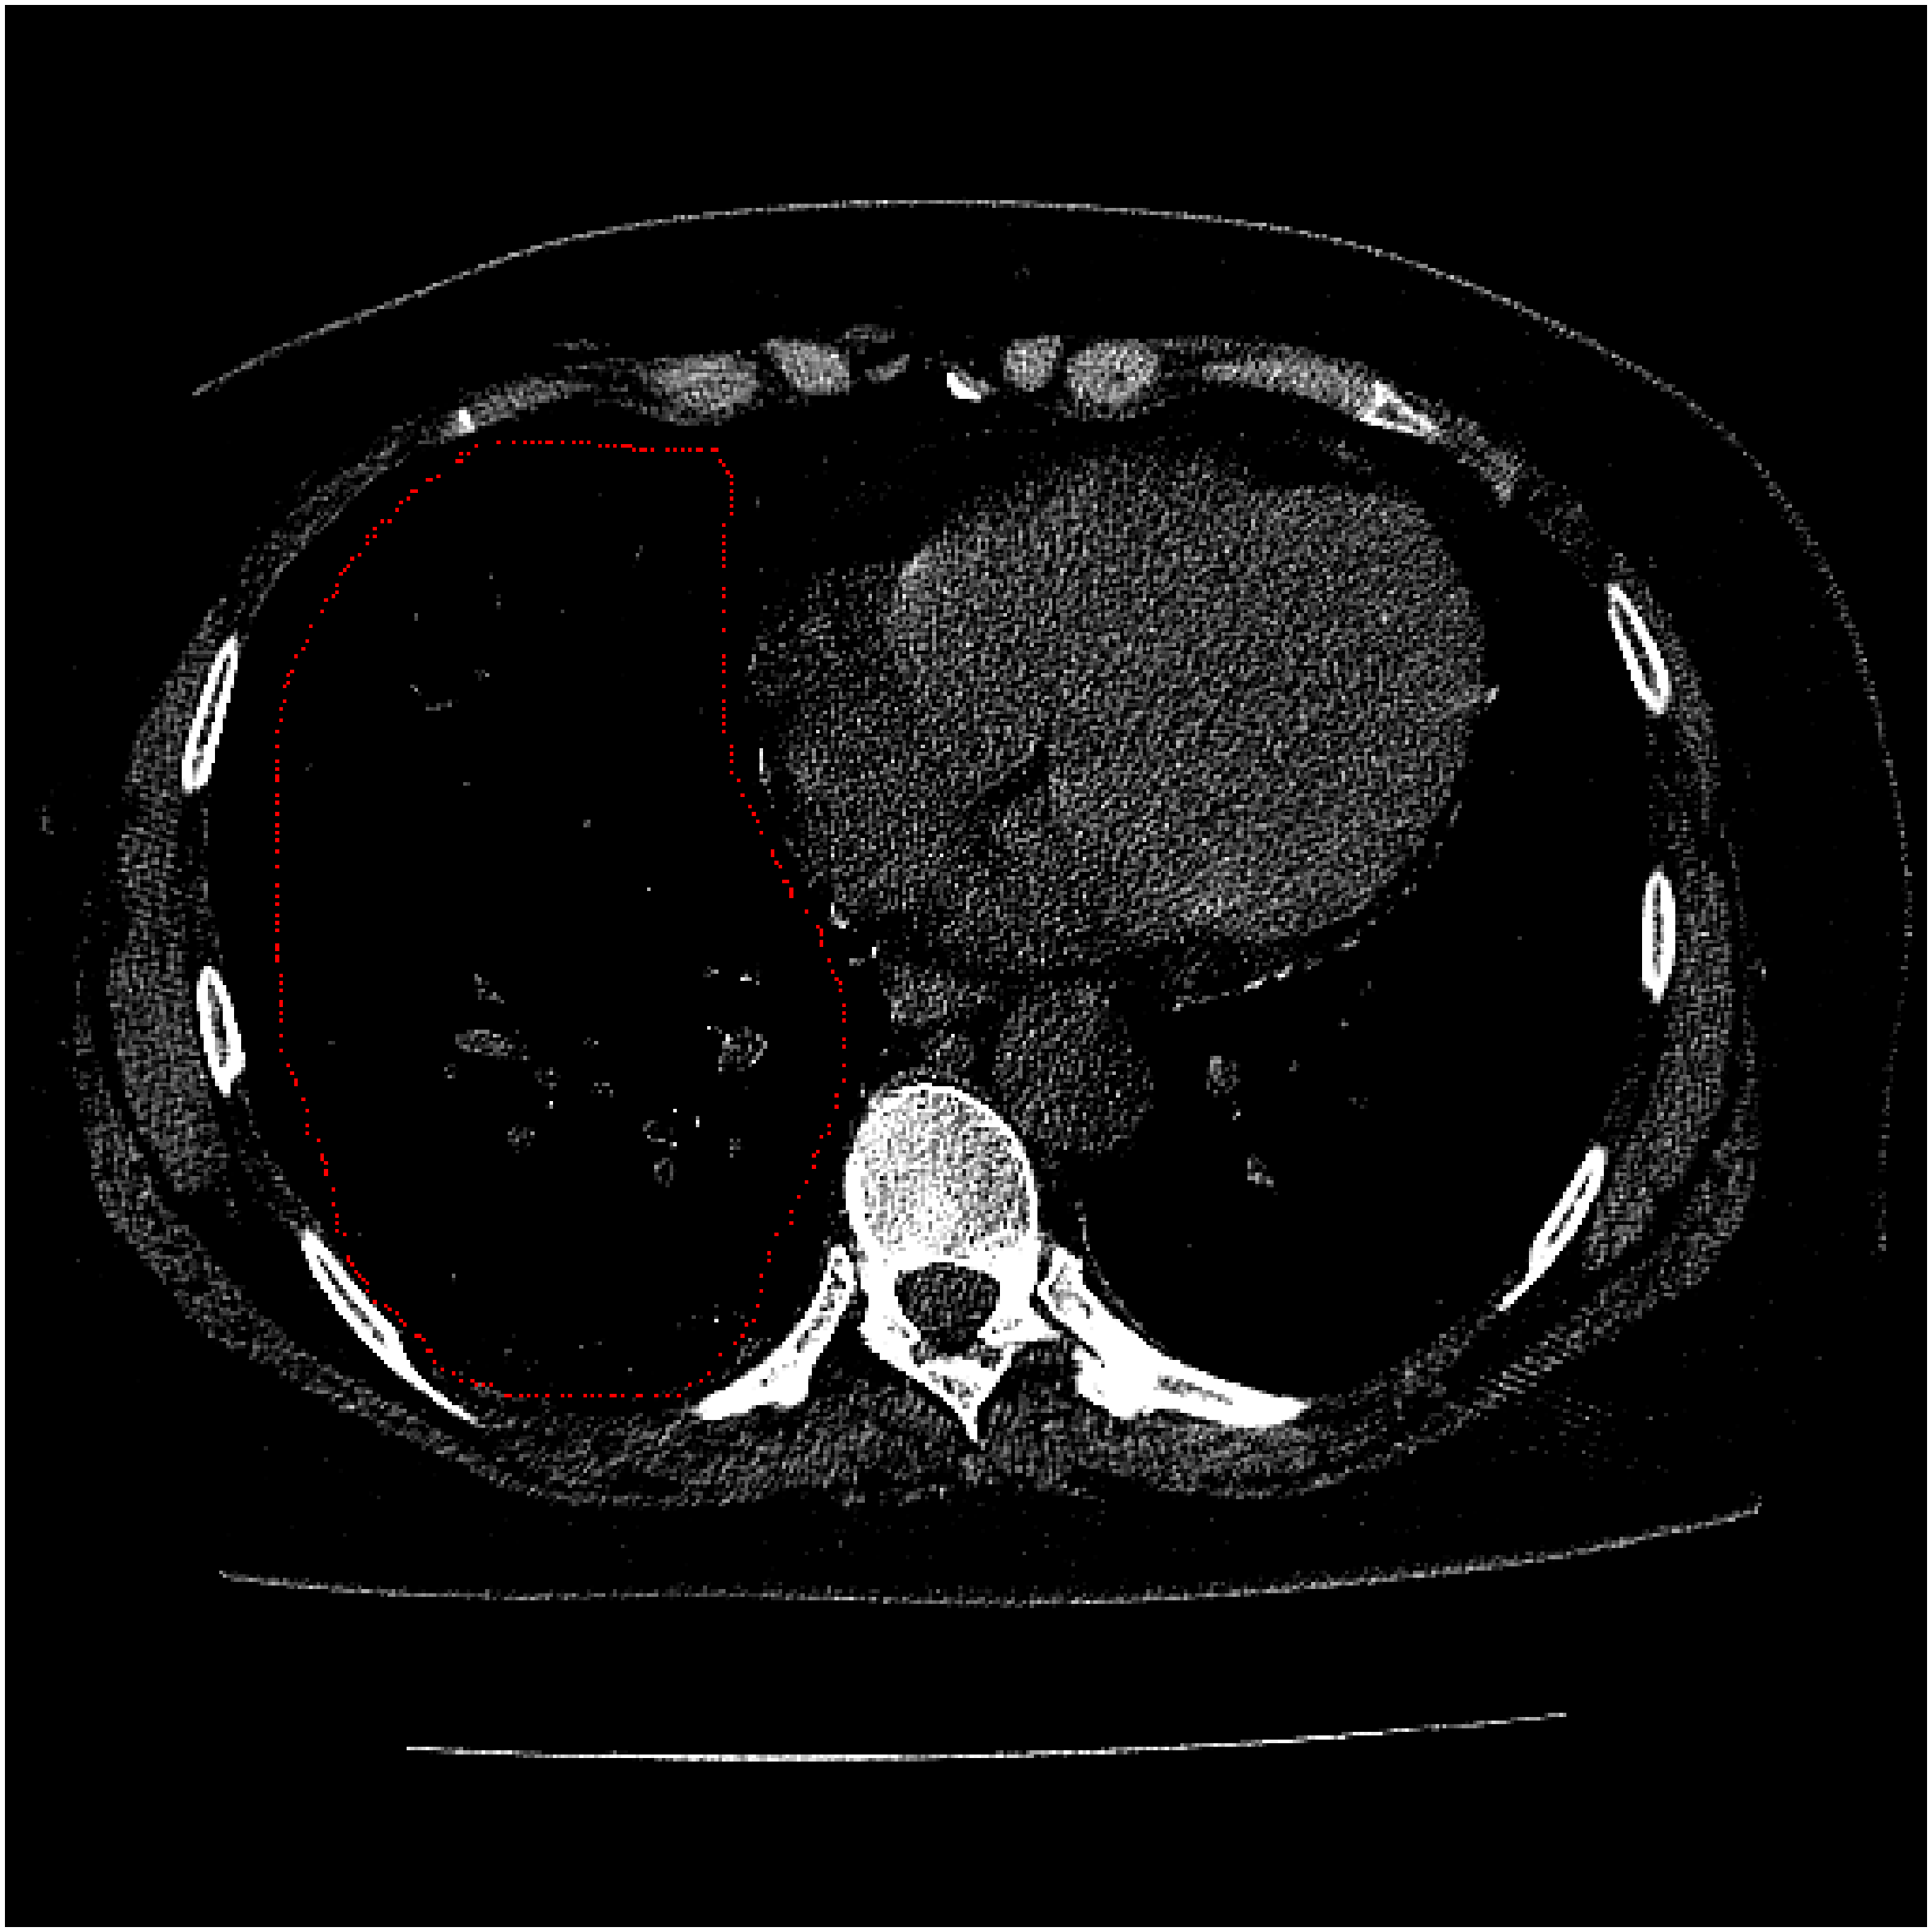

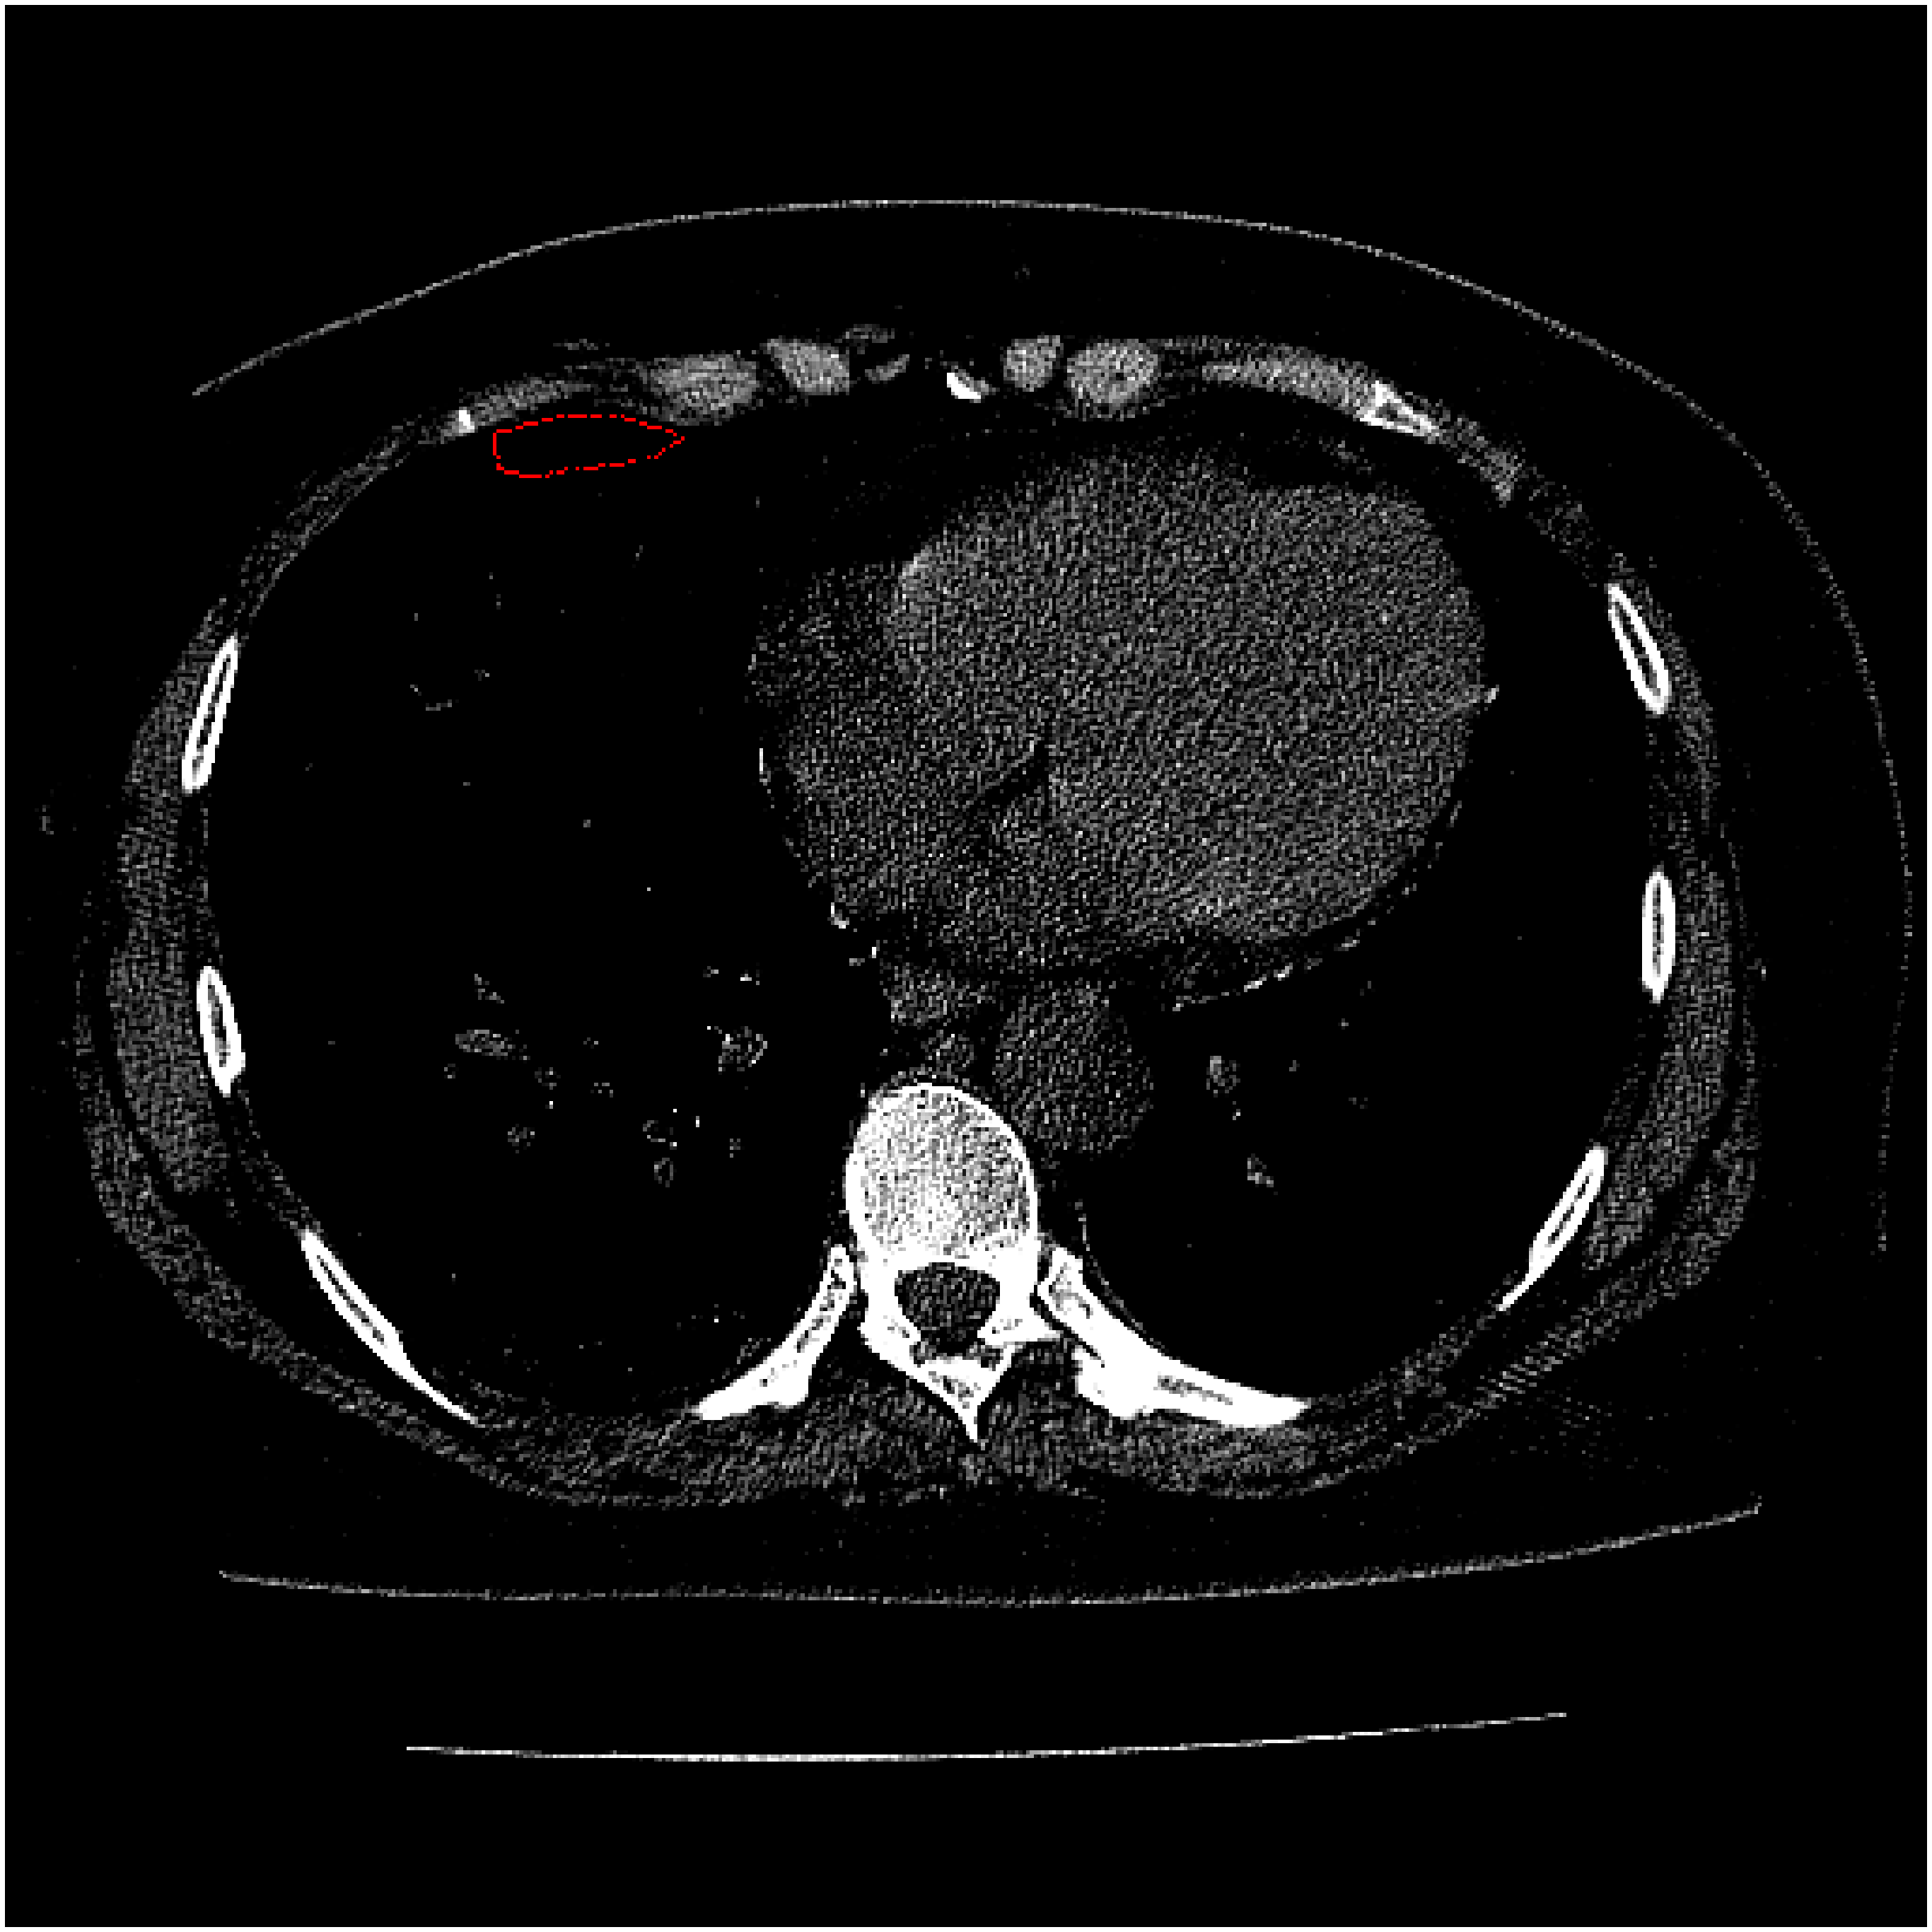

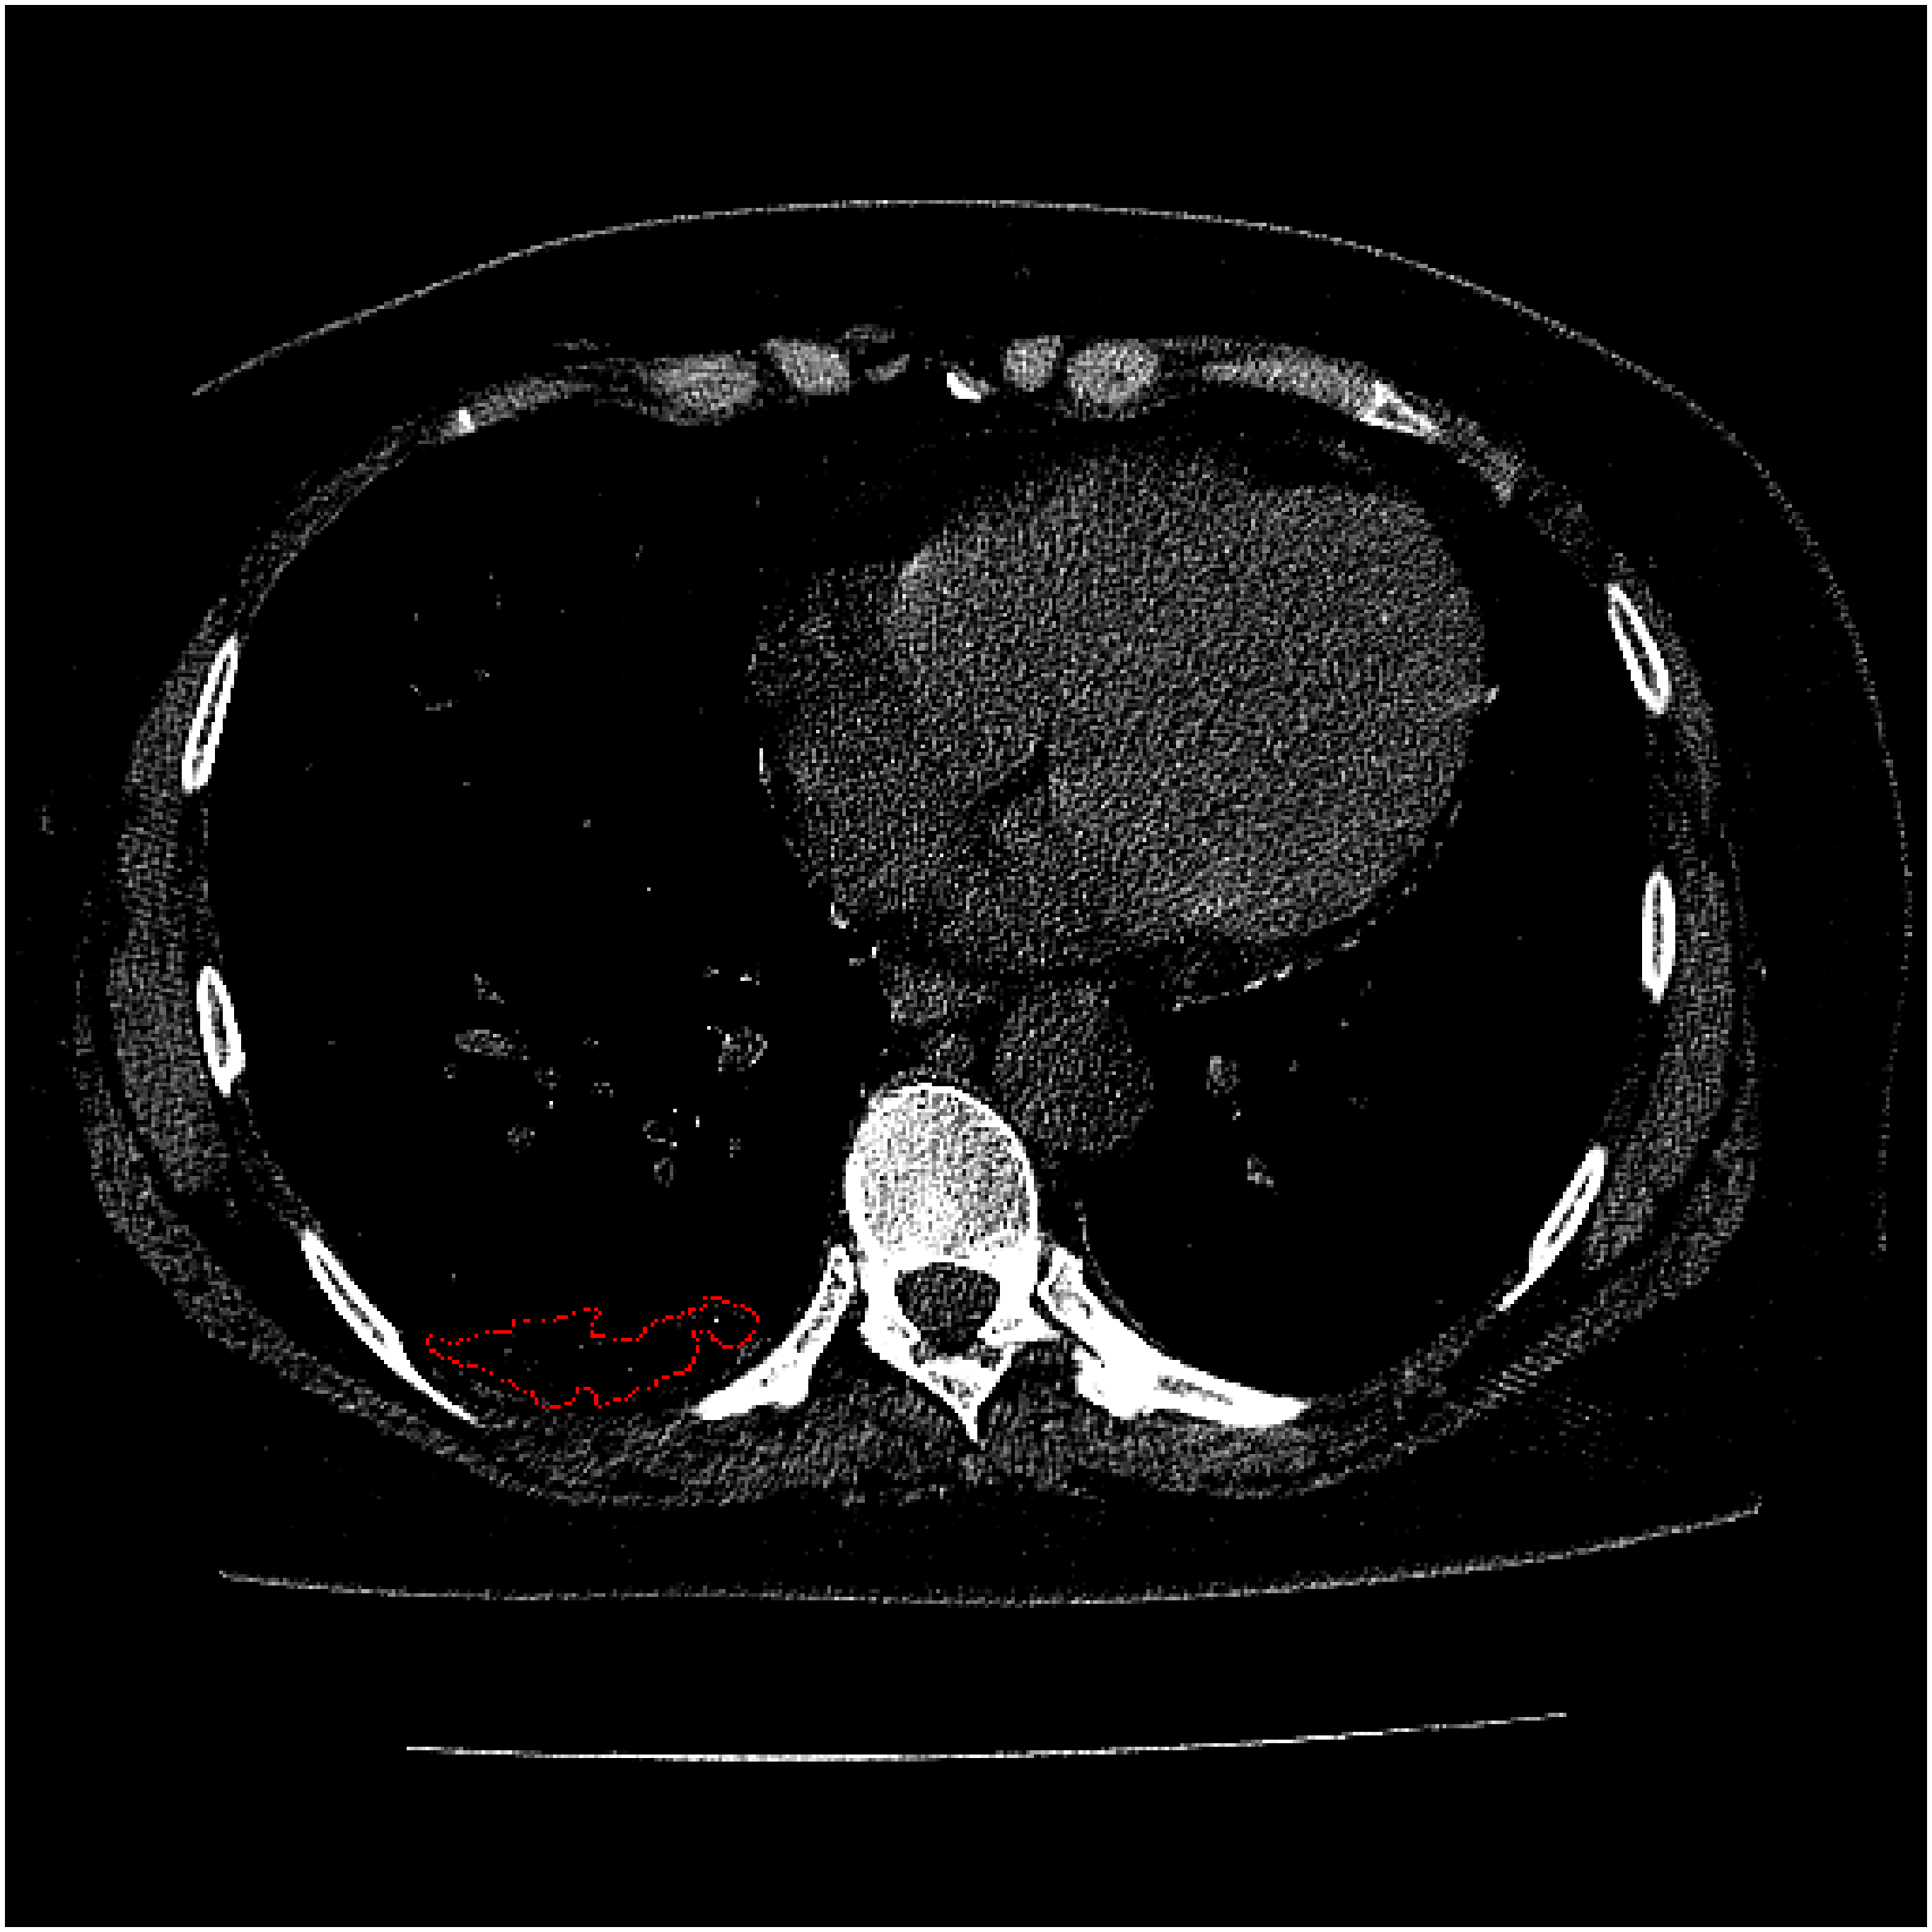

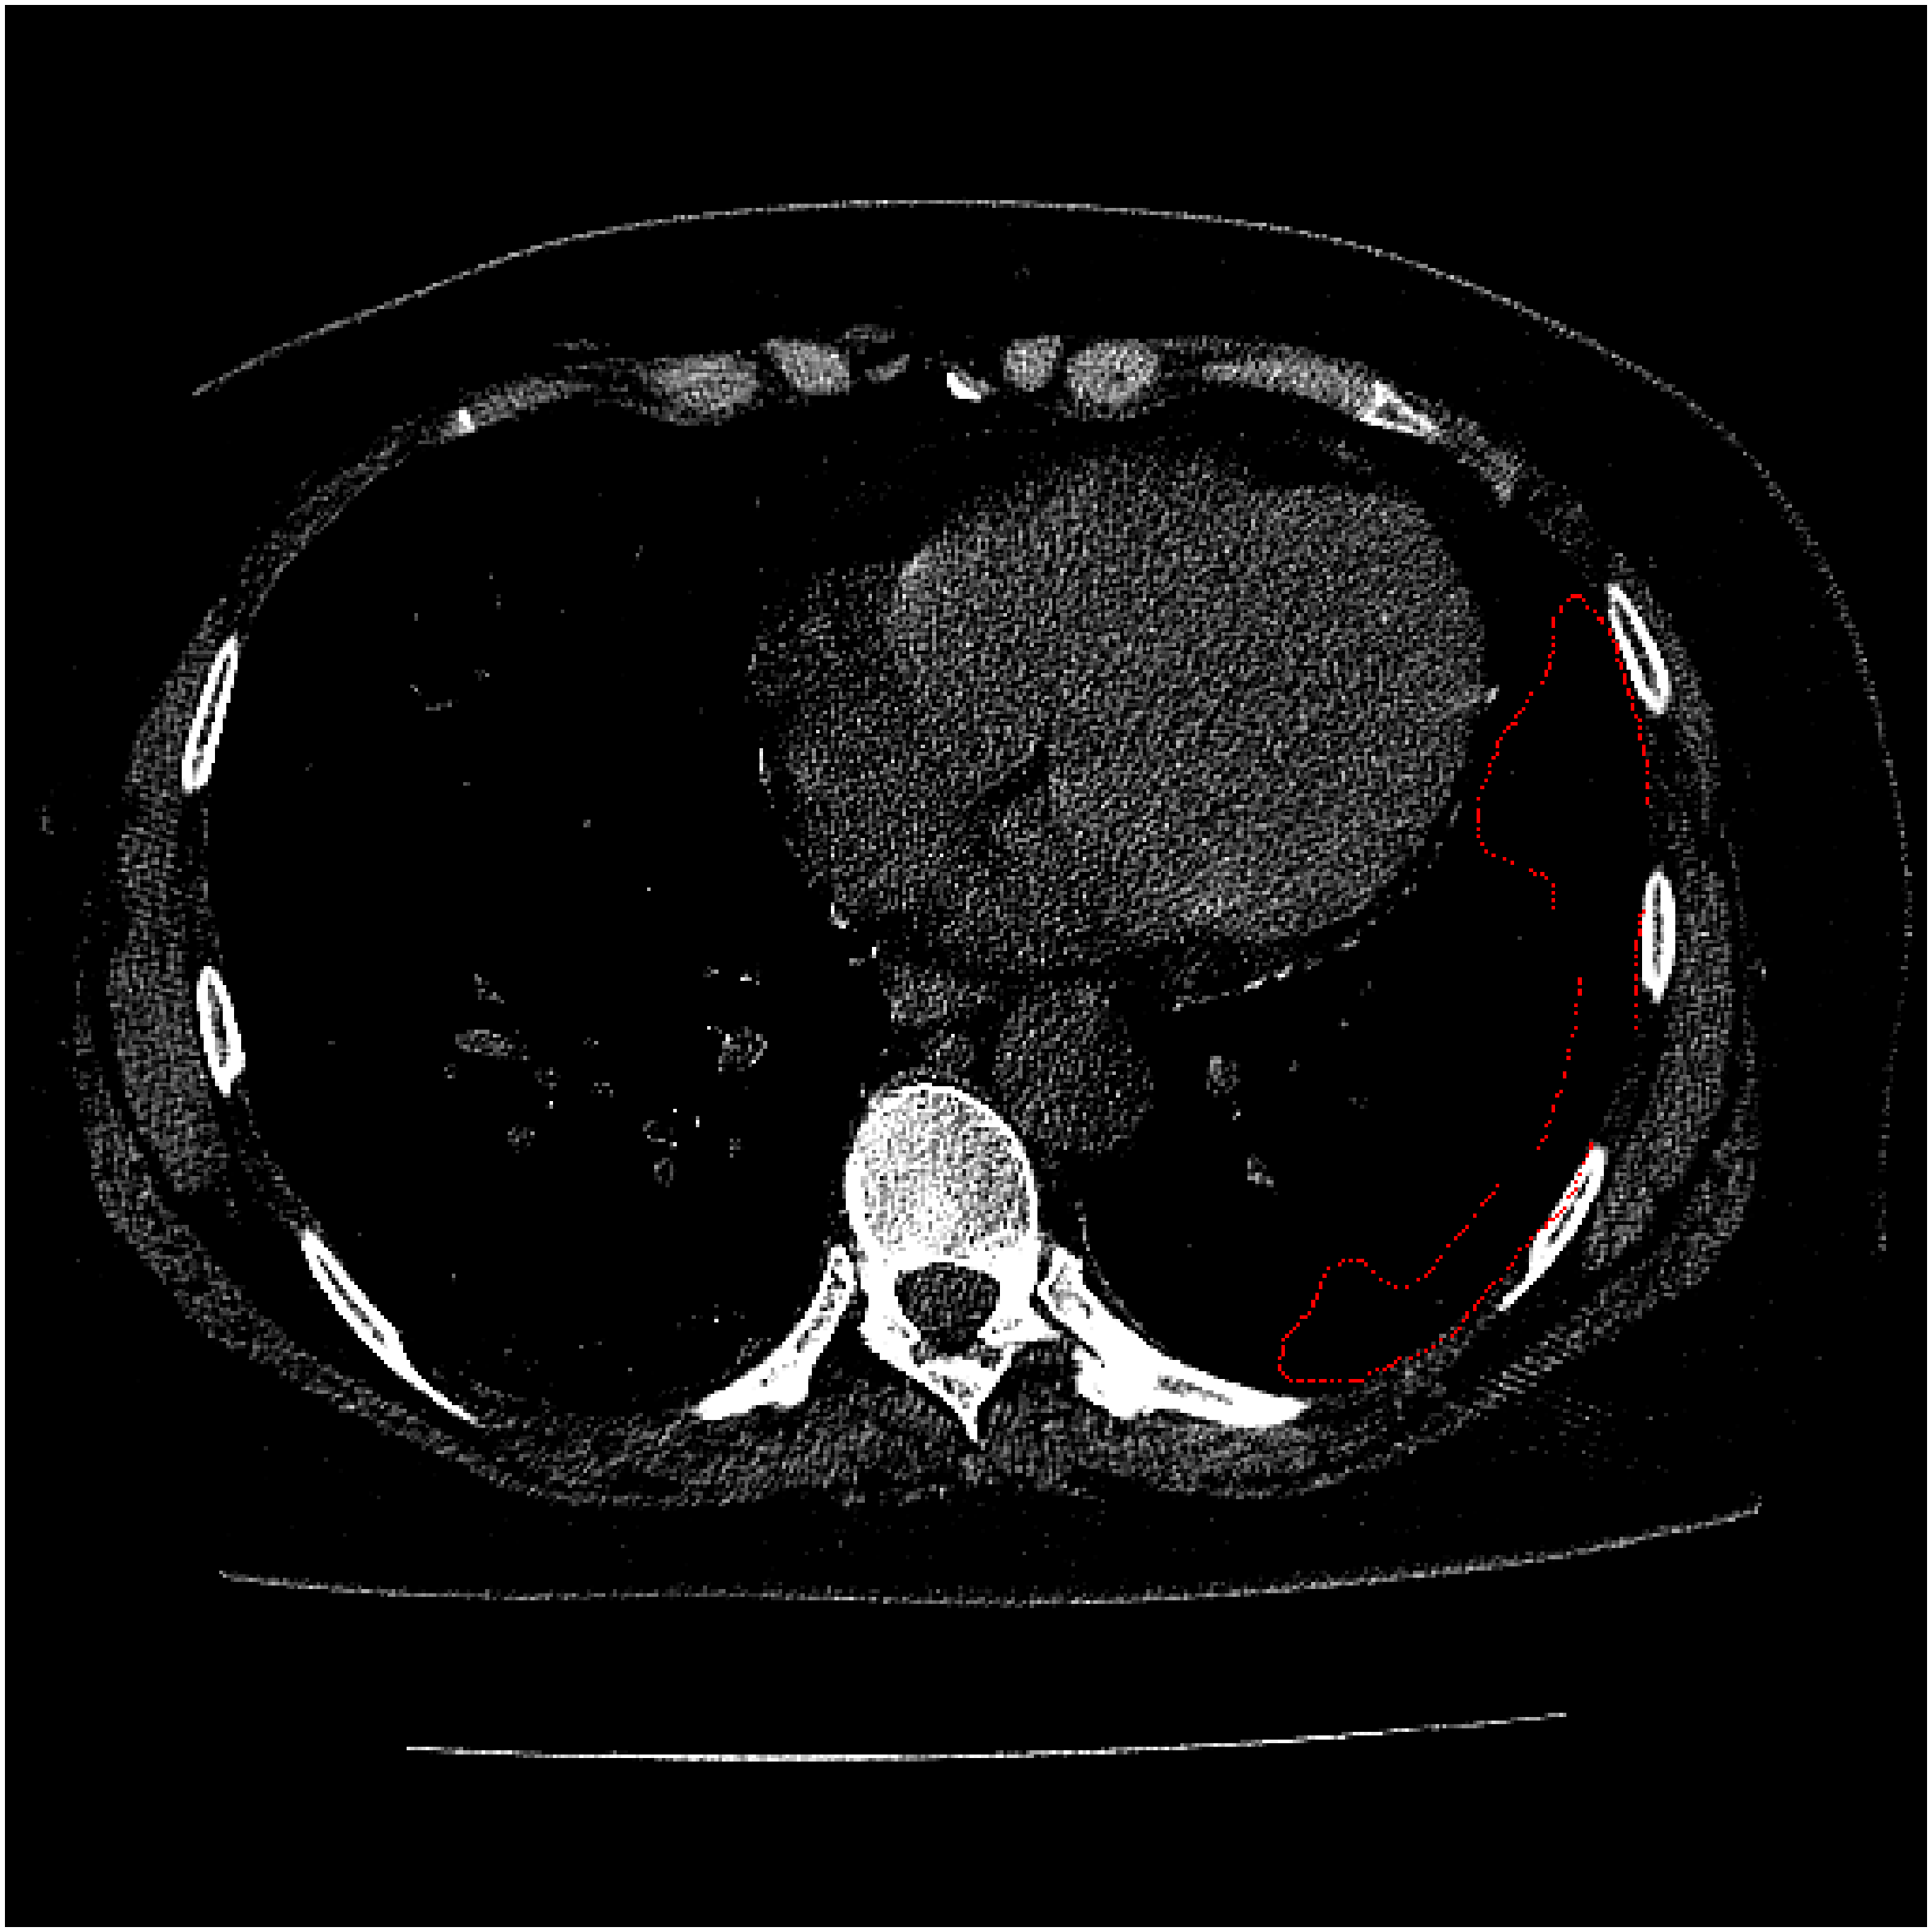

In [10]:
doc = [0, 1, 2, 3]
dicom = ['0b791bcb-a3f6-11ea-8690-d5dc0d8782d9.dcm', '29a7b38f-a3f6-11ea-8690-0ff0934ed20e.dcm']

for i in dicom:
    for j in doc:
        path = str(j) + "___" + str(i)
        draw(parsed[path])
        print(parsed[path]['label'])

Далее будем искать метрику IoU. Для этого прописываем функции расчета этой метрики, куда в качестве аргументов посылаются координаты коробок, а именно x, y, width, height. 

In [12]:
import tensorflow as tf
def calculate_iou(y_true, y_pred):    
    results = []
 
    x_boxTrue_tleft = y_true[0]  
    y_boxTrue_tleft = y_true[1]
    boxTrue_width = y_true[2]
    boxTrue_height = y_true[3]
    area_boxTrue = (boxTrue_width * boxTrue_height)
    
    x_boxPred_tleft = y_pred[0]
    y_boxPred_tleft = y_pred[1]
    boxPred_width = y_pred[2]
    boxPred_height = y_pred[3]
    area_boxPred = (boxPred_width * boxPred_height)

    x_boxTrue_br = x_boxTrue_tleft + boxTrue_width
    y_boxTrue_br = y_boxTrue_tleft + boxTrue_height 
    x_boxPred_br = x_boxPred_tleft + boxPred_width
    y_boxPred_br = y_boxPred_tleft + boxPred_height 

    x_boxInt_tleft = np.max([x_boxTrue_tleft,x_boxPred_tleft])
    y_boxInt_tleft = np.max([y_boxTrue_tleft,y_boxPred_tleft]) 
 
    x_boxInt_br = np.min([x_boxTrue_br,x_boxPred_br])
    y_boxInt_br = np.min([y_boxTrue_br,y_boxPred_br]) 
       
    area_of_intersection = \
    np.max([0,(x_boxInt_br - x_boxInt_tleft)]) * np.max([0,(y_boxInt_br - y_boxInt_tleft)])

    iou = area_of_intersection / ((area_boxTrue + area_boxPred) - area_of_intersection)

    iou = iou.astype(np.float32)
        
    results.append(iou)
    
    
    return np.mean(results)

In [13]:
def IoU(y_true, y_pred):

    iou = tf.py_func(calculate_iou, [y_true, y_pred], tf.float32)

    return iou

Далее прописываем функцию, с помощью которой будем получать из всех точек разметки коробку.

In [14]:
def y_list(parsed_i):
    aa = len(parsed_i['boxes'])
    tmp_x = []
    tmp_y = []
    for i in range(aa):
        tmp_x.append(parsed_i['boxes'][i][0])
        tmp_y.append(parsed_i['boxes'][i][1])
    maxx = max(tmp_x)
    minx = min(tmp_x)
    maxy = max(tmp_y)
    miny = min(tmp_y)

    height = maxy - miny
    width = maxx - minx
    y_0 = [minx, maxy, width, height]
    return y_0

Ниже функция уже выдает значение метрики.

In [19]:
def iou_for_two_doc(doc_pid1, doc_pid2, dicom):
    common1 = str(doc_pid1) + "___" + str(dicom)
    common2 = str(doc_pid2) + "___" + str(dicom)
    y_1 = y_list(parsed[common1])
    #print(y_1)
    y_2 = y_list(parsed[common2])
    #print(y_2)
    ret = calculate_iou(y_1, y_2)
    print("IoU for doctor "+ str(doc_pid1) + " and doctor " + str(doc_pid2) + " is " + str(ret) + " on dicom image " + str(dicom))
    

In [20]:
iou_for_two_doc(2, 3, '29a7b38f-a3f6-11ea-8690-0ff0934ed20e.dcm')

IoU for doctor 2 and doctor 3 is 0.0 on dicom image 29a7b38f-a3f6-11ea-8690-0ff0934ed20e.dcm


In [21]:
iou_for_two_doc(0, 3, '0b791bcb-a3f6-11ea-8690-d5dc0d8782d9.dcm')

IoU for doctor 0 and doctor 3 is 0.47817177 on dicom image 0b791bcb-a3f6-11ea-8690-d5dc0d8782d9.dcm
